In [1]:
from six.moves import urllib
from scipy.io import loadmat
import os

mnist_path = os.path.join(".", "datasets", "mnist-original.mat")

if os.path.exists(mnist_path)==False:
    # download dataset from github.
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat" 
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
else:
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Done!")

Done!


In [2]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt

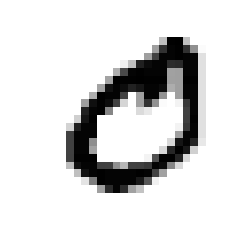

In [7]:
some_digit = X[1]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap= matplotlib.cm.binary, interpolation= "nearest")
plt.axis("off")
plt.show()

In [8]:
y[1]

0.0

### 1.将训练集与测试集分离

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
import numpy as np

In [11]:
#使用此函数来生成 0 - 59999之间不重复的随机排列
shuffle_index = np.random.permutation(60000) 
x_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### 2.简化问题
#### 2.1 训练一个二分类器

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test ==5)

In [13]:
from sklearn.linear_model import SGDClassifier
#随机梯度下降分类器并不是一个独立的算法，而是一系列利用随机梯度下降求解参数的算法的集合。

In [14]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)
# max_iter 被指定为算法训练epoch的次数
# tol 被指定为算法停止的标准。在0.21版本中，默认为1e-3

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
import sklearn
sklearn.__version__
#看起来以上的随机梯度下降分类器模型所使用参数是训练epoch=5就停止

'0.20.0'

In [16]:
sgd_clf.predict([some_digit])

array([False])

### 3.对性能的评估
#### 3.1使用交叉验证测量准确性

In [17]:
#使用第二章的知识对数据进行K折交叉检验
#并且我们往往希望测试集当中的数据与训练集当中的数据有相同的分布
#避免出现因为测试集中包含某一类样本过多使得精度度量失去意义 使用分层抽样解决此问题
#此时分层抽样的依据往往是训练样本中的label分布
#分层抽样在进行训练集与测试集分离以及进行交叉检验时都有涉及，需要注意
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [18]:
X_train.shape

(60000, 784)

In [19]:
import pandas as pd

In [20]:
label = pd.DataFrame(y_train_5,columns=["label"])
label["label"].value_counts()

False    54579
True      5421
Name: label, dtype: int64

In [21]:
skfolds = StratifiedKFold(n_splits = 3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    #应产生总数为40000张的训练集和20000张的测试集
    #训练集包含有36000张不是5的图片和4000张是5的图片（尽量）
    #测试集包含有18000张不是5的图片和2000张是5的图片（尽量）
    #其中训练集包含 5 的图片占总数的9.035%
    #测试集中包含5的图片占总数的9.035%
    Train_5_count = y_train[train_index]
    m1=0
    for i in Train_5_count:
        #print(i)
        if i == 5:
            m1=m1+1
    print(m1)
    Test_5_count = y_train[test_index]
    m2=0
    for i in Test_5_count:
        #print(i)
        if i == 5:
            m2=m2+1
    print(m2)
#     y_train[train_index]
#     y_test[test_index]
    print(str(m1/40000*100)+"%    "+str(m2/20000*100)+"%")
    

3614
1807
9.035%    9.035%
3614
1807
9.035%    9.035%
3614
1807
9.035%    9.035%


In [22]:
skfolds = StratifiedKFold(n_splits = 3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    #应产生总数为40000张的训练集和20000张的测试集
    #训练集包含有36000张不是5的图片和4000张是5的图片（尽量）
    #测试集包含有18000张不是5的图片和2000张是5的图片（尽量）
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) #

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.9017


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.8606


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.875


In [23]:
# stratifiedKFold：保证训练集中每一类的比例是相同的（尽量）
#n_splits代表产生k折 同样的，相当于产生k组数据    sss.split(X,y)中的
#参数y则通过计算分布来使训练集与测试集中数据的类别分布一致
#当总数为6的样本数被要求分为2折，其中分布为0.5,0.5时，由分布为先

import numpy as np
from sklearn.model_selection import StratifiedKFold
X_stratifiedKFold=np.array([[1,2],[3,4],[5,6],[7,8],[9,10],[11,12]])
y_stratifiedKFold=np.array([1,1,1,2,2,2])
skf=StratifiedKFold(n_splits=2)
print(skf)
for train_index,test_index in skf.split(X_stratifiedKFold,y_stratifiedKFold):
    print("Train Index:",train_index,",Test Index:",test_index)

StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
Train Index: [2 5] ,Test Index: [0 1 3 4]
Train Index: [0 1 3 4] ,Test Index: [2 5]


In [24]:
# StratifiedShuffleSplit 把数据集打乱顺序，然后划分测试集和训练集，
# 训练集额和测试集的比例随机选定，训练集和测试集的比例的和可以小于1,
#但是还要保证训练集中各类所占的比例是一样的
#n_splits代表产生k折     test_size代表测试集所占比例  sss.split(X,y)中的
#参数y则通过计算分布来使训练集与测试集中数据的类别分布一致

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
X_StratifiedShuffleSplit=np.array([[1,2],[3,4],[5,6],[7,8],[9,10],[11,12]])
y_StratifiedShuffleSplit=np.array([1,1,1,2,2,2])
sss=StratifiedShuffleSplit(n_splits=2,test_size=.3,random_state=0)
#sss.get_n_splits(X,y)
print(sss)
for train_index,test_index in sss.split(X_StratifiedShuffleSplit,y_StratifiedShuffleSplit):
    print("Train Index:",train_index,",Test Index:",test_index)

StratifiedShuffleSplit(n_splits=2, random_state=0, test_size=0.3,
            train_size=None)
Train Index: [2 5 1 3] ,Test Index: [0 4]
Train Index: [0 4 3 1] ,Test Index: [2 5]


In [25]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv =3,scoring = "accuracy")

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. I

array([0.9017, 0.8606, 0.875 ])

In [26]:
#在使用分层K折的思想时  你会发现所有的测试折合在一起   就可以覆盖整个参与交叉验证 的集合
#所以在使用cross_val_predict（）这个函数时，可以发回来一组基于参与所有数据的预测值

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. I

In [27]:
#pandas包中也有相应的函数

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52532,  2047],
       [ 5207,   214]], dtype=int64)

In [28]:
import pandas as pd

pd.crosstab(y_train_5,y_train_pred,rownames=["label"],colnames=["precidion"])

precidion,False,True
label,,
False,52532,2047
True,5207,214


[base64str]: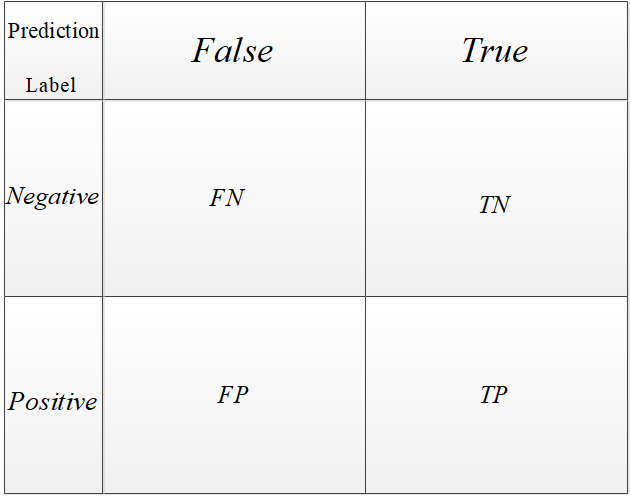

[base64str]: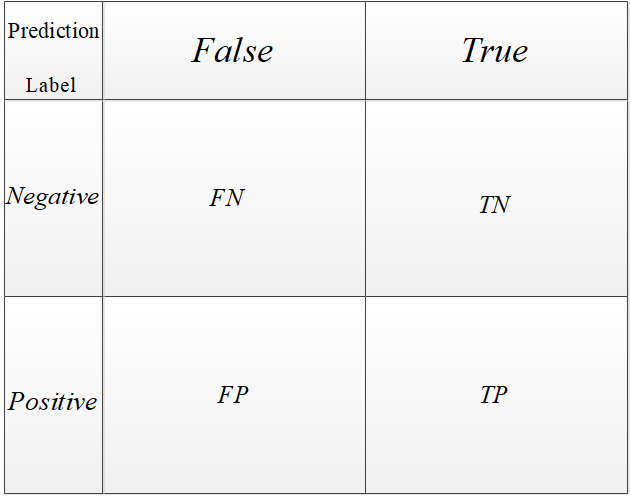

<img src="https://raw.githubusercontent.com/JackDemo/hands-on-ml-with-sklearn-and-tf/master/images/%E4%BA%8C%E7%BB%B4%E6%B7%B7%E6%B7%86%E7%9F%A9%E9%98%B5.png" width = "300" height = "300" div align=center />

True Positive(真正，TP)：将正类预测为正类数

True Negative(真负，TN)：将负类预测为负类数

False Positive(假正，FP)：将负类预测为正类数误报 (Type I error)

False Negative(假负，FN)：将正类预测为负类数→漏报 (Type II error)

$$precision=\frac{TP}{TP+FP}$$ 
准确率：向儿童推送适合其年龄段观看的视频，此时我们希望误报（FP）次数减少，影响导致选择准确率高但召回率低的分类器

$$recall=\frac{TP}{TP+FN}$$ 
召回率：向警察推送窃贼出现的警报，此时我们希望漏报（TN）次数减少，影响导致选择准确率高但召回率低的分类器

### 准确率与召回率

In [38]:
from sklearn.metrics import precision_score,recall_score,f1_score

In [39]:
precision_score(y_train_5,y_train_pred)

0.0946483856700575

In [40]:
recall_score(y_train_5, y_train_pred)

0.03947611141855746

In [41]:
f1_score(y_train_5, y_train_pred)

0.055714657641239264